In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import os.path as osp
import json
import math
from glob import glob
from pprint import pprint

import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
import albumentations as A
import lanms
from albumentations.pytorch import ToTensorV2
from imageio import imread

from model import EAST
from detect import detect

# 1. 데이터셋 살펴보기

별도로 제공한 `convert_mlt.py` 스크립트로 생성된 데이터셋을 불러오는데, 본 예시에서는 한글 샘플들만으로 구성된 subset인 `ICDAR17_Koean`을 이용함.

In [3]:
DATASET_DIR = '/data/datasets/ICDAR17_Korean'  # FIXME

### 어노테이션 살펴보기


어노테이션은 UFO에 맞춰 작성되어 있습니다. (UFO에 대한 자세한 설명은 5강 내용을 참조)

어노테이션에는 다양한 정보가 포함되어 있는데, EAST 학습에 이용되는 정보는 아래와 같습니다.

1. `points`: word bounding box를 나타내는 좌표값
   - shape: (N, 4, 2)
2. `illegibility`: 식별이 어려운 글자인지의 여부
   - 일반적으로 `illegibility=True`인 글자 영역은 masking을 통해 학습에서 무시하도록 처리함.

In [4]:
ufo_fpath = osp.join(DATASET_DIR, 'ufo/train.json')
with open(ufo_fpath, 'r') as f:
    ufo_anno = json.load(f)

In [5]:
print(ufo_anno.keys())

dict_keys(['images'])


In [6]:
print(len(ufo_anno['images']))

536


### 일부 샘플들의 이름 확인

이미지 파일명을 샘플의 ID로 이용함.

In [6]:
sample_ids = sorted(ufo_anno['images'])
print(sample_ids[:10])

['img_1001.jpg', 'img_1002.jpg', 'img_1003.jpg', 'img_1004.jpg', 'img_1011.jpg', 'img_1015.jpg', 'img_1017.jpg', 'img_1019.jpg', 'img_1023.jpg', 'img_1024.jpg']


### 첫 번째 샘플에 대한 어노테이션 내용 확인

6개의 단어를 포함하고 있고, 모두 유효한(`illegibility=False`) 단어들임.

In [8]:
first_sample_id = sample_ids[0]
pprint(ufo_anno['images'][first_sample_id])

{'img_h': 1836,
 'img_w': 2448,
 'license_tag': {'commercial': True,
                 'holder': None,
                 'public': True,
                 'type': 'CC-BY-SA',
                 'usability': True},
 'tags': None,
 'words': {'0': {'illegibility': False,
                 'language': ['ko'],
                 'orientation': 'Horizontal',
                 'points': [[80.0, 807.0],
                            [607.0, 812.0],
                            [592.0, 1037.0],
                            [126.0, 1037.0]],
                 'transcription': '얼음,',
                 'word_tags': None},
           '1': {'illegibility': False,
                 'language': ['ko'],
                 'orientation': 'Horizontal',
                 'points': [[678.0, 793.0],
                            [1160.0, 803.0],
                            [1155.0, 1037.0],
                            [691.0, 1037.0]],
                 'transcription': '석유',
                 'word_tags': None},
           '2': 

### 예시로 특정 샘플 살펴보기

In [7]:
SAMPLE_IDX = 209

sample_id = sample_ids[SAMPLE_IDX]  # `sample_id`가 곧 이미지 파일명
image_fpath = osp.join(DATASET_DIR, 'images', sample_id)
image = imread(image_fpath)

print('Image:\t{}'.format(image.shape))

bboxes, labels = [], []
for word_info in ufo_anno['images'][sample_id]['words'].values():
    bboxes.append(np.array(word_info['points']))
    labels.append(int(not word_info['illegibility']))
bboxes, labels = np.array(bboxes, dtype=np.float32), np.array(labels, dtype=np.float32)

print('Bounding boxes:\t{}'.format(bboxes.shape))
print('Labels:\t{}'.format(labels.shape))

Image:	(2448, 1836, 3)
Bounding boxes:	(5, 4, 2)
Labels:	(5,)


### 이미지와 어노테이션 정보 시각화

In [3]:
def draw_bbox(image, bbox, color=(0, 0, 255), thickness=1, thickness_sub=None, double_lined=False,
              write_point_numbers=False):
    """이미지에 하나의 bounding box를 그려넣는 함수
    """
    thickness_sub = thickness_sub or thickness * 3
    basis = max(image.shape[:2])
    fontsize = basis / 1500
    x_offset, y_offset = int(fontsize * 12), int(fontsize * 10)
    color_sub = (255 - color[0], 255 - color[1], 255 - color[2])

    points = [(int(np.rint(p[0])), int(np.rint(p[1]))) for p in bbox]

    for idx in range(len(points)):
        if double_lined:
            cv2.line(image, points[idx], points[(idx + 1) % len(points)], color_sub,
                     thickness=thickness_sub)
        cv2.line(image, points[idx], points[(idx + 1) % len(points)], color, thickness=thickness)

    if write_point_numbers:
        for idx in range(len(points)):
            loc = (points[idx][0] - x_offset, points[idx][1] - y_offset)
            if double_lined:
                cv2.putText(image, str(idx), loc, cv2.FONT_HERSHEY_SIMPLEX, fontsize, color_sub,
                            thickness_sub, cv2.LINE_AA)
            cv2.putText(image, str(idx), loc, cv2.FONT_HERSHEY_SIMPLEX, fontsize, color, thickness,
                        cv2.LINE_AA)


def draw_bboxes(image, bboxes, color=(0, 0, 255), thickness=1, thickness_sub=None,
                double_lined=False, write_point_numbers=False):
    """이미지에 다수의 bounding box들을 그려넣는 함수
    """
    for bbox in bboxes:
        draw_bbox(image, bbox, color=color, thickness=thickness, thickness_sub=thickness_sub,
                  double_lined=double_lined, write_point_numbers=write_point_numbers)
        

def gray_mask_to_heatmap(x):
    x = cv2.cvtColor(cv2.applyColorMap(x, cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB)
    return x


def get_superimposed_image(image, score_map, heatmap=True, w_image=None, w_map=None):
    """이미지에 map/mask 등을 중첩하여 그려주는 함수
    
    Args:
        image (ndarray): (H, W, C) shaped, float32 or uint8 dtype is allowed.
        score_map (ndarray): (H, W) shaped, float32 or uint8 dtype is allowed.
        heatmap (boot): Wheather to convert `score_map` into a heatmap.
        w_image (float)
        w_map (float)

    Blending weights(`w_image` and `w_map`) are default to (0.4, 0.6).
    """

    assert w_image is None or (w_image > 0 and w_image < 1)
    assert w_map is None or (w_map > 0 and w_map < 1)

    if image.dtype != np.uint8:
        image = (255 * np.clip(image, 0, 1)).astype(np.uint8)

    if score_map.dtype != np.uint8:
        score_map = (255 * np.clip(score_map, 0, 1)).astype(np.uint8)
    if heatmap:
        score_map = gray_mask_to_heatmap(score_map)
    elif score_map.ndim == 2 or score_map.shape[2] != 3:
        score_map = cv2.cvtColor(score_map, cv2.COLOR_GRAY2RGB)

    if w_image is None and w_map is None:
        w_image, w_map = 0.4, 0.6
    elif w_image is None:
        w_image = 1 - w_map
    elif w_map is None:
        w_map = 1 - w_image

    return cv2.addWeighted(image, w_image, score_map, w_map, 0)

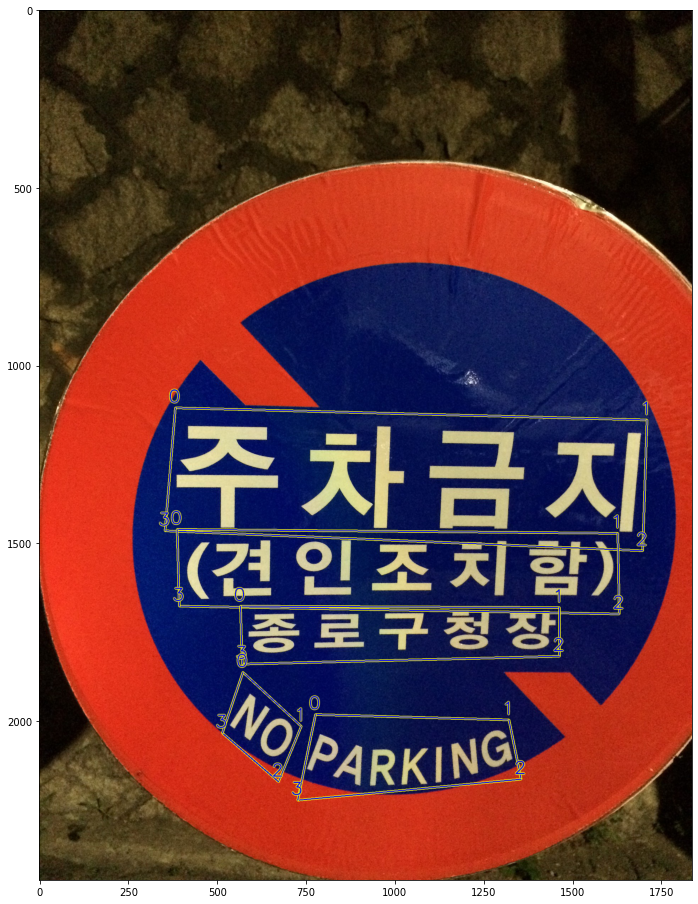

In [9]:
vis = image.copy()
draw_bboxes(vis, bboxes, double_lined=True, thickness=2, thickness_sub=5, write_point_numbers=True)

plt.figure(figsize=(16, 16))
plt.imshow(vis)

# 2. EAST 모델 학습을 위한 데이터 처리

EAST 모델 학습을 위해서는 2가지의 GT 레이블을 생성해야 함. (자세한 내용은 강의자료 참조)

1. Score map : 글자 영역 중 중심 영역을 예측
2. Geometry map: 글자 영역의 경계와 글자의 각도를 예측

### 자세히 살펴보기 위해 특정 글자 영역 중심으로 RoI 설정

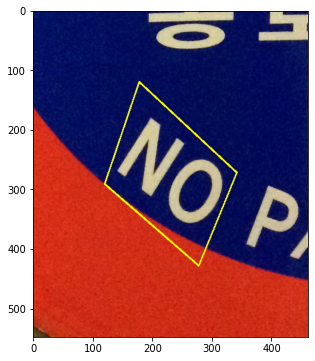

In [10]:
WORD_IDX = 3
VIEW_MARGIN = 120  # pixels
ROI_FIG_SIZE = (6, 6)

target_bbox = np.round(bboxes[WORD_IDX]).astype(np.int32)

x_min, y_min = np.min(target_bbox, axis=0)
x_max, y_max = np.max(target_bbox, axis=0)
src_points = np.array([[x_min - VIEW_MARGIN, y_min - VIEW_MARGIN],
                       [x_max + VIEW_MARGIN, y_min - VIEW_MARGIN],
                       [x_max + VIEW_MARGIN, y_max + VIEW_MARGIN],
                       [x_min - VIEW_MARGIN, y_max + VIEW_MARGIN]], dtype=np.float32)
dst_points = np.array([[0, 0],
                       [x_max - x_min + 2 * VIEW_MARGIN, 0],
                       [x_max - x_min + 2 * VIEW_MARGIN, y_max - y_min + 2 * VIEW_MARGIN],
                       [0, y_max - y_min + 2 * VIEW_MARGIN]], dtype=np.float32)
roi_patch = cv2.warpPerspective(
    image,
    cv2.getPerspectiveTransform(src_points, dst_points),
    dsize=(x_max - x_min + 2 * VIEW_MARGIN, y_max - y_min + 2 * VIEW_MARGIN),
)
target_bbox[:, 0] -= x_min - VIEW_MARGIN
target_bbox[:, 1] -= y_min - VIEW_MARGIN

vis = roi_patch.copy()
draw_bbox(vis, target_bbox, color=(255, 255, 0), thickness=2)

plt.figure(figsize=ROI_FIG_SIZE)
plt.imshow(vis)

### Score map 초기화

가로/세로의 크기는 이미지(직전에 생성한 `roi_patch`)의 1/4

In [11]:
MAP_SCALE = 0.25
INV_MAP_SCALE = int(1 / MAP_SCALE)

print(f'{INV_MAP_SCALE=}')

INV_MAP_SCALE=4


Image size: (548, 462, 3)
Score map size: (137, 115, 1)
Geometry map: (137, 115, 5)


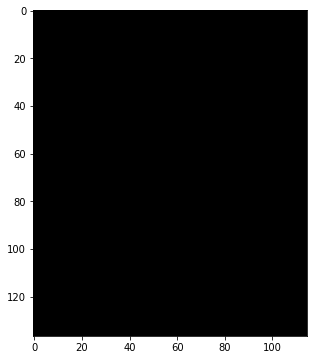

In [12]:
img_h, img_w = roi_patch.shape[:2]
map_h, map_w = int(img_h * MAP_SCALE), int(img_w * MAP_SCALE)

score_map = np.zeros((map_h, map_w, 1), np.float32)
geo_map = np.zeros((map_h, map_w, 5), np.float32)

print('Image size: {}'.format(roi_patch.shape))
print('Score map size: {}'.format(score_map.shape))
print('Geometry map: {}'.format(geo_map.shape))

plt.figure(figsize=ROI_FIG_SIZE)
plt.imshow(score_map, cmap='gray')

### Bounding box shrinking -> Center region 계산

EAST는 bounding box의 전체 영역이 아니라 center region에 대한 segmentation을 수행하는 방식임.

In [13]:
def shrink_bbox(bbox, coef=0.3, inplace=False, max_sides=None):
    """Bounding box의 center region을 계산하는 함수
    """
    # 네 변의 길이 계산
    lens = [np.linalg.norm(bbox[i] - bbox[(i + 1) % 4], ord=2) for i in range(4)]
    r = [min(lens[(i - 1) % 4], lens[i]) for i in range(4)]
    
    if not inplace:
        bbox = bbox.copy()
    
    offset = 0 if lens[0] + lens[2] > lens[1] + lens[3] else 1
    cnt_moved = 0
    for idx in [0, 2, 1, 3]:
        if max_sides is not None and cnt_moved >= max_sides:
            break
            
        p1_idx, p2_idx = (idx + offset) % 4, (idx + 1 + offset) % 4
        p1p2 = bbox[p2_idx] - bbox[p1_idx]
        dist = np.linalg.norm(p1p2)
        if dist <= 1:
            continue
        bbox[p1_idx] = bbox[p1_idx] + p1p2 / dist * r[p1_idx] * coef
        bbox[p2_idx] = bbox[p2_idx] - p1p2 / dist * r[p2_idx] * coef
        cnt_moved += 1
        
    return bbox

### 가로/세로 중 긴 쪽부터 Shrinking 적용

`SHRINK_N_SIDES` 변경하면 중간 과정을 확인할 수 있음.

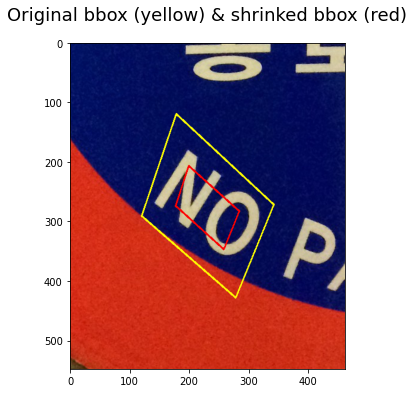

In [16]:
SHRINK_N_SIDES = 4  # FIXME [0, 1, 2, 3, 4]

shrinked_bbox = shrink_bbox(target_bbox, max_sides=SHRINK_N_SIDES)

vis = roi_patch.copy()
draw_bbox(vis, target_bbox, color=(255, 255, 0), thickness=2)
draw_bbox(vis, shrinked_bbox, color=(255, 0, 0), thickness=2)

plt.figure(figsize=ROI_FIG_SIZE)
plt.title('Original bbox (yellow) & shrinked bbox (red)', fontsize=18, y=1.05)
plt.imshow(vis)

### Center region 기반으로 Score map 생성

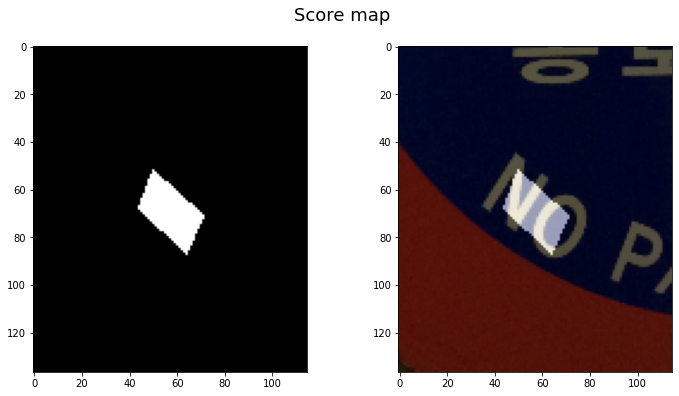

In [17]:
poly = np.round(MAP_SCALE * shrinked_bbox).astype(np.int32)
cv2.fillPoly(score_map, [poly], 1)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(ROI_FIG_SIZE[0] * 2, ROI_FIG_SIZE[1]))
plt.suptitle('Score map', fontsize=18, y=0.97)
axs[0].imshow(score_map, cmap='gray')
axs[1].imshow(get_superimposed_image(cv2.resize(roi_patch, dsize=(map_w, map_h)), score_map, heatmap=False))

### Geometry map 초기화

가로/세로의 크기는 이미지 크기의 1/4

5개 채널로 구성됨.

- 상/하/좌/우 방향으로 글자 영역의 경계선까지의 거리 예측: d1, d2, d3, d4
- 글자의 각도 예측: θ

Image size: (548, 462, 3)
Geometry map: (137, 115, 5)


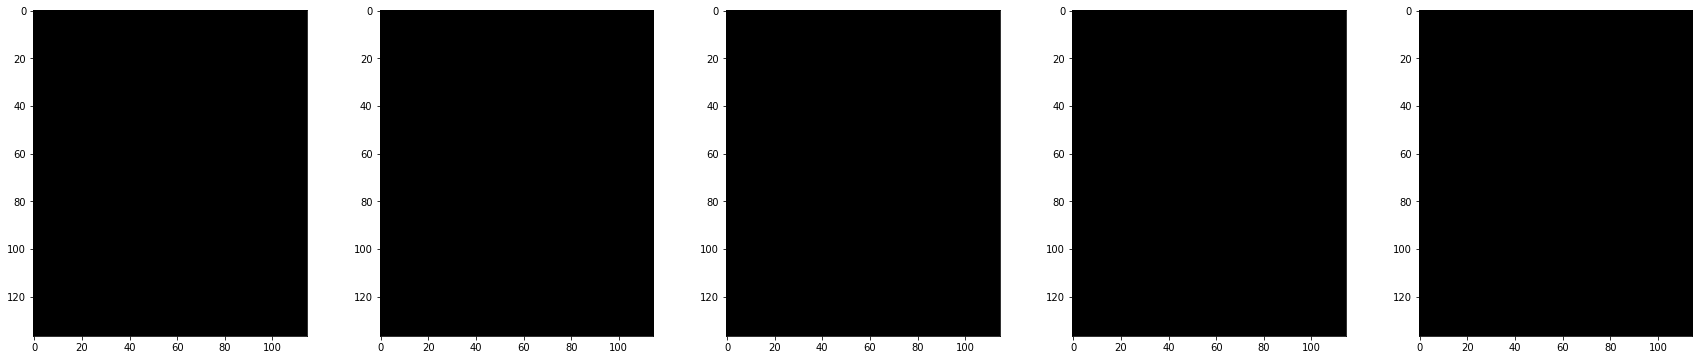

In [18]:
img_h, img_w = roi_patch.shape[:2]
map_h, map_w = int(img_h * MAP_SCALE), int(img_w * MAP_SCALE)

geo_map = np.zeros((map_h, map_w, 5), np.float32)

print('Image size: {}'.format(roi_patch.shape))
print('Geometry map: {}'.format(geo_map.shape))

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(ROI_FIG_SIZE[0] * 5, ROI_FIG_SIZE[1]))
for idx in range(5):
    axs[idx].imshow(geo_map[..., idx], cmap='gray')

### Bounding box의 각도 계산

각도의 방향(부호)과 의미에 주의해야 함.

이미지 공간에서의 각도는 시계방향을 양(+)의 방향으로 설정

`find_min_rect_angle`로 계산한 각도는 min-rect를 만들기 위해 "회전해야하는 각도" (현재 bbox의 각도가 아님.)

In [20]:
def get_rotate_mat(theta):
    """주어진 각도에 대한 회전 변환 행렬을 계산하는 함수
    """
    return np.array([[math.cos(theta), -math.sin(theta)],
                     [math.sin(theta), math.cos(theta)]])


def calc_error_from_rect(bbox):
    """
    Default orientation is x1y1 : left-top, x2y2 : right-top, x3y3 : right-bot, x4y4 : left-bot.
    Calculate the difference between the vertices orientation and default orientation.
    """
    x_min, y_min = np.min(bbox, axis=0)
    x_max, y_max = np.max(bbox, axis=0)
    rect = np.array([[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]],
                    dtype=np.float32)
    return np.linalg.norm(bbox - rect, axis=0).sum()


def rotate_bbox(bbox, theta, anchor=None):
    points = bbox.T
    if anchor is None:
        anchor = points[:, :1]
    rotated_points = np.dot(get_rotate_mat(theta), points - anchor) + anchor
    return rotated_points.T


def find_min_rect_angle(bbox, rank_num=10):
    """
    Find the best angle to rotate poly and obtain min rectangle.
    """
    areas = []
    angles = np.arange(-90, 90) / 180 * math.pi
    for theta in angles:
        rotated_bbox = rotate_bbox(bbox, theta)
        x_min, y_min = np.min(rotated_bbox, axis=0)
        x_max, y_max = np.max(rotated_bbox, axis=0)
        areas.append((x_max - x_min) * (y_max - y_min))

    best_angle, min_error = -1, float('inf')
    for idx in np.argsort(areas)[:rank_num]:
        rotated_bbox = rotate_bbox(bbox, angles[idx])
        error = calc_error_from_rect(rotated_bbox)
        if error < min_error:
            best_angle, min_error = angles[idx], error
    
    return best_angle

(-1.0, 1.0)

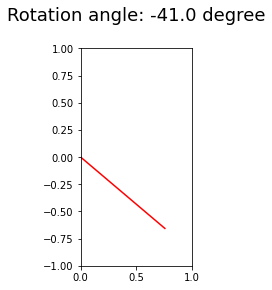

In [21]:
theta = find_min_rect_angle(target_bbox)

plt.figure(figsize=(2, 4))
plt.plot([0, math.cos(theta)], [0, math.sin(theta)], 'r-')
plt.title('Rotation angle: {} degree'.format(theta * 180 / math.pi), fontsize=18, y=1.1)
plt.xlim([0, 1])
plt.ylim([-1, 1])

### RBOX 형태로 변환된 GT bounding box 확인

각 픽셀에서의 RBOX의 네 변에 대한 거리가 Distance map(d1, d2, d3, d4)을 구성하는 값이 됨.

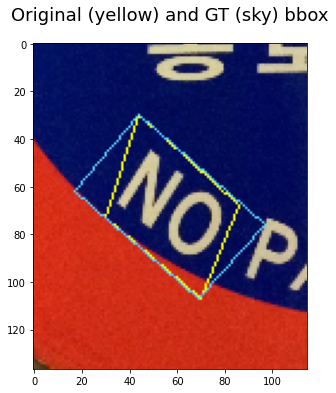

In [21]:
center_mask = np.zeros((map_h, map_w), np.float32)
poly = np.round(MAP_SCALE * shrinked_bbox).astype(np.int32)
cv2.fillPoly(center_mask, [poly], 1)

rotated_bbox = rotate_bbox(target_bbox, theta)
rotated_bbox *= MAP_SCALE

x_min, y_min = np.min(rotated_bbox, axis=0)
x_max, y_max = np.max(rotated_bbox, axis=0)

gt_rbox = np.array([[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]],
                   dtype=np.float32)
gt_rbox = rotate_bbox(gt_rbox, -theta)

plt.figure(figsize=ROI_FIG_SIZE)
plt.title('Original (yellow) and GT (sky) bbox', fontsize=18, y=1.05)
vis = cv2.resize(roi_patch, dsize=(map_w, map_h))
draw_bbox(vis, target_bbox * MAP_SCALE, color=(255, 255, 0))
draw_bbox(vis, gt_rbox, color=(85, 206, 255))
plt.imshow(vis, cmap='gray')

### Distance map(d1, d2, d3, d4)의 기반 생성

Bounding box의 각도만큼 회전된 축 상에서 두 축을 따라 값이 선형적으로 증가하는 Map을 각각 생성함.

In [22]:
def get_rotated_coords(h, w, theta, anchor):
    anchor = anchor.reshape(2, 1)
    rotate_mat = get_rotate_mat(theta)
    x, y = np.meshgrid(np.arange(w), np.arange(h))  # x.shape = y.shape = (h, w)
    x_lin = x.reshape((1, x.size))
    y_lin = y.reshape((1, y.size))
    coord_mat = np.concatenate((x_lin, y_lin), 0)
    rotated_coord = np.dot(rotate_mat, coord_mat - anchor) + anchor
    rotated_x = rotated_coord[0, :].reshape(x.shape)
    rotated_y = rotated_coord[1, :].reshape(y.shape)
    return rotated_x, rotated_y

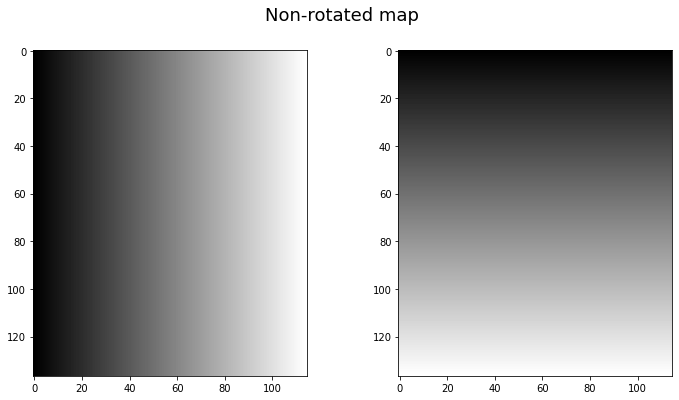

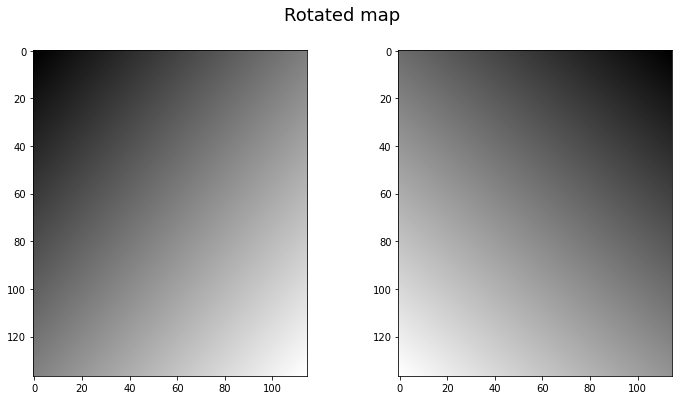

In [23]:
rotated_x, rotated_y = get_rotated_coords(map_h, map_w, 0, target_bbox[0] * MAP_SCALE)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(ROI_FIG_SIZE[0] * 2, ROI_FIG_SIZE[1]))
plt.suptitle('Non-rotated map', fontsize=18)
axs[0].imshow(rotated_x, cmap='gray')
axs[1].imshow(rotated_y, cmap='gray')


rotated_x, rotated_y = get_rotated_coords(map_h, map_w, theta, target_bbox[0] * MAP_SCALE)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(ROI_FIG_SIZE[0] * 2, ROI_FIG_SIZE[1]))
plt.suptitle('Rotated map', fontsize=18)
axs[0].imshow(rotated_x, cmap='gray')
axs[1].imshow(rotated_y, cmap='gray')

### Distance map(d1, d2, d3, d4) 생성

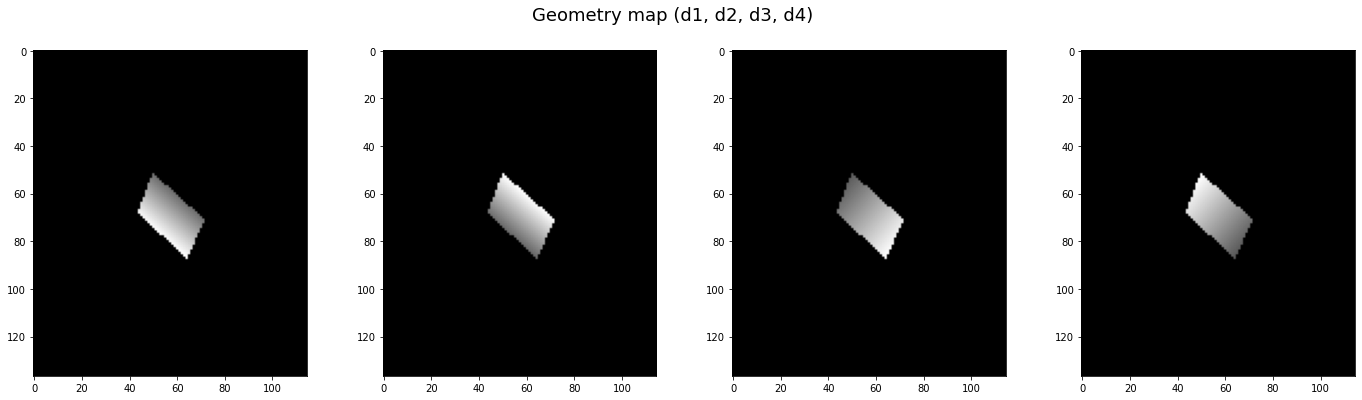

In [33]:
d1, d2 = rotated_y - y_min, y_max - rotated_y
d1[d1 < 0] = 0
d2[d2 < 0] = 0
d3, d4 = rotated_x - x_min, x_max - rotated_x
d3[d3 < 0] = 0
d4[d4 < 0] = 0

geo_map[:, :, 0] += d1 * center_mask * INV_MAP_SCALE
geo_map[:, :, 1] += d2 * center_mask * INV_MAP_SCALE
geo_map[:, :, 2] += d3 * center_mask * INV_MAP_SCALE
geo_map[:, :, 3] += d4 * center_mask * INV_MAP_SCALE

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(ROI_FIG_SIZE[0] * 4, ROI_FIG_SIZE[1]))
plt.suptitle('Geometry map (d1, d2, d3, d4)', fontsize=18)
for idx in range(4):
    vis = geo_map[:, :, idx]
    axs[idx].imshow(geo_map[:, :, idx], cmap='gray')

### Angle map(θ) 생성

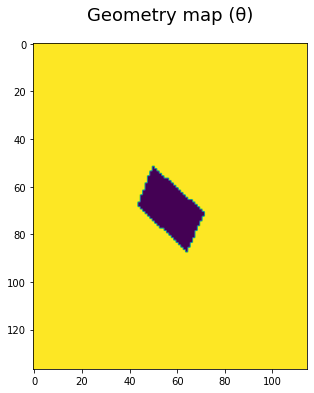

In [98]:
geo_map[:, :, 4] += theta * center_mask

plt.figure(figsize=ROI_FIG_SIZE)
plt.title('Geometry map (θ)', fontsize=18, y=1.05)
plt.imshow(geo_map[:, :, 4])

### Distance map 시각화

시각화를 위해 d1, d2, d3, d4의 값을 [0, 1]의 값으로 조절함. (학습에는 원본 버전을 이용)

In [26]:
def normalize_geo_map(geo_map):
    """
    Use this method for visualization purposes only.
    """
    geo_map = geo_map.copy()
    for channel in range(4):
        num_blobs, idx_map = cv2.connectedComponents(np.array(geo_map[:, :, channel] > 0, dtype=np.uint8))
        for blob_idx in range(1, num_blobs):
            blob_region = idx_map == blob_idx
            geo_map[:, :, channel][blob_region] /= geo_map[:, :, channel][blob_region].max()
    return (geo_map * 255).astype(np.uint8)

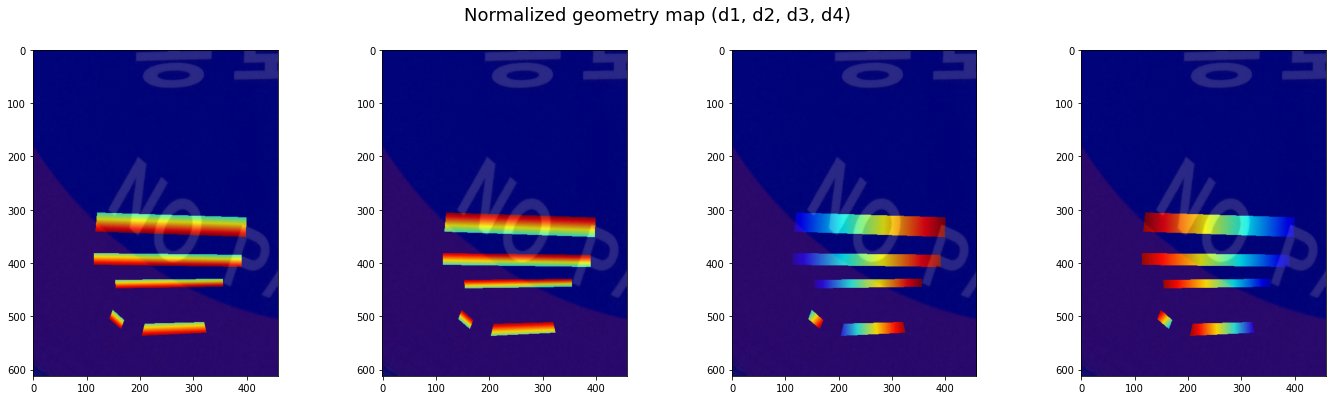

In [27]:
img = cv2.resize(roi_patch, dsize=(score_map.shape[1], score_map.shape[0]))
vis_geo_map = normalize_geo_map(geo_map)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(ROI_FIG_SIZE[0] * 4, ROI_FIG_SIZE[1]))
plt.suptitle('Normalized geometry map (d1, d2, d3, d4)', fontsize=18)
for idx in range(4):
    axs[idx].imshow(get_superimposed_image(img, vis_geo_map[:, :, idx], w_map=0.8))

### GT bbox 영역 내의 Geometry map 시각화

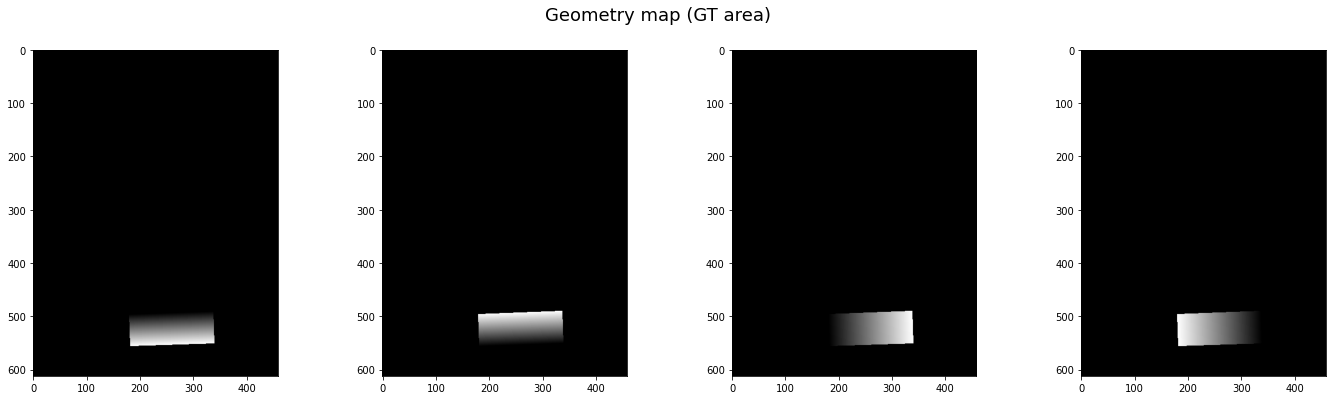

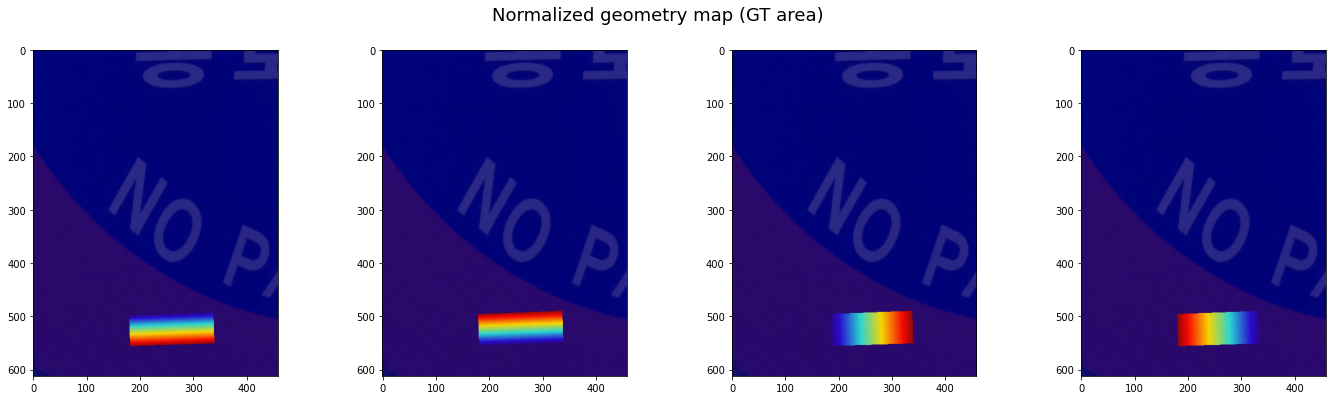

In [28]:
geo_map_rbox = np.zeros((map_h, map_w, 4), np.float32)

x_min, y_min = np.min(rotated_bbox, axis=0)
x_max, y_max = np.max(rotated_bbox, axis=0)

gt_rbox = np.array([[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]],
                   dtype=np.float32)
gt_rbox = rotate_bbox(gt_rbox, -theta)
gt_rbox_mask = np.zeros((map_h, map_w), np.float32)
cv2.fillPoly(gt_rbox_mask, [np.round(gt_rbox).astype(np.int32)], 1)

geo_map_rbox[:, :, 0] += d1 * gt_rbox_mask * INV_MAP_SCALE
geo_map_rbox[:, :, 1] += d2 * gt_rbox_mask * INV_MAP_SCALE
geo_map_rbox[:, :, 2] += d3 * gt_rbox_mask * INV_MAP_SCALE
geo_map_rbox[:, :, 3] += d4 * gt_rbox_mask * INV_MAP_SCALE

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(ROI_FIG_SIZE[0] * 4, ROI_FIG_SIZE[1]))
plt.suptitle('Geometry map (GT area)', fontsize=18)
for idx in range(4):
    axs[idx].imshow(geo_map_rbox[:, :, idx], cmap='gray')
    
img = cv2.resize(roi_patch, dsize=(score_map.shape[1], score_map.shape[0]))
vis_geo_map_rbox = normalize_geo_map(geo_map_rbox)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(ROI_FIG_SIZE[0] * 4, ROI_FIG_SIZE[1]))
plt.suptitle('Normalized geometry map (GT area)', fontsize=18)
for idx in range(4):
    axs[idx].imshow(get_superimposed_image(img, vis_geo_map_rbox[:, :, idx], w_map=0.8))

### 모든 글자 영역에 대해 각각 이 과정을 수행 -> 한 샘플에 대한 GT를 생성

Image:		(2448, 1836, 3)
Score map:	(612, 459, 1)
Geometry map:	(612, 459, 5)


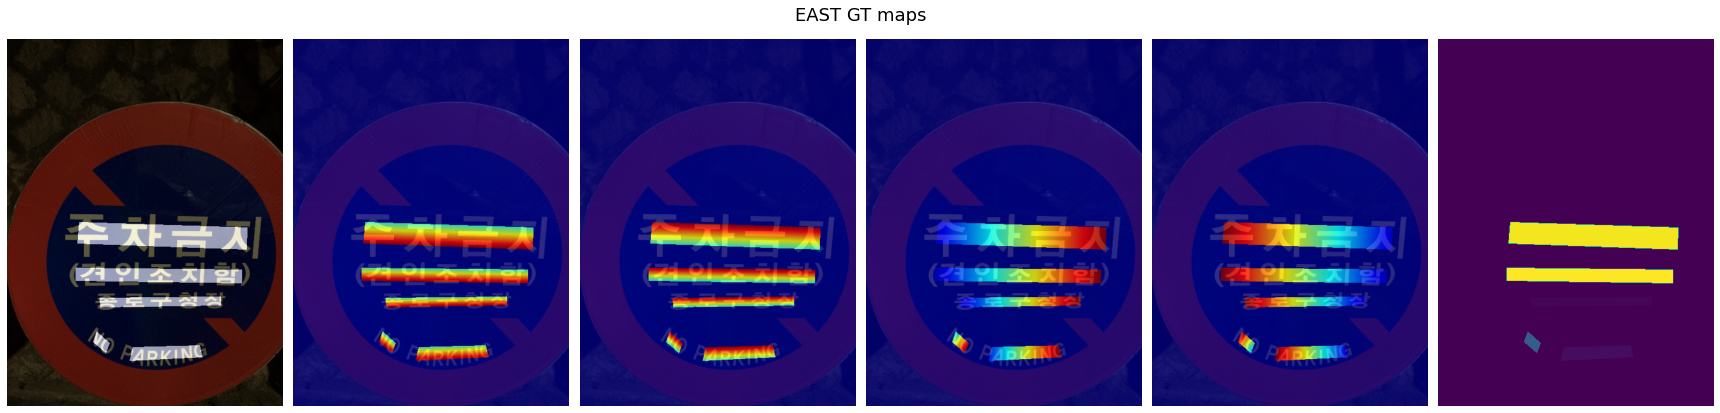

In [29]:
MAP_SCALE = 0.25
INV_MAP_SCALE = int(1 / MAP_SCALE)

img_h, img_w = image.shape[:2]
map_h, map_w = int(img_h * MAP_SCALE), int(img_w * MAP_SCALE)

score_map = np.zeros((map_h, map_w, 1), np.float32)
geo_map = np.zeros((map_h, map_w, 5), np.float32)

print('Image:\t\t{}'.format(image.shape))
print('Score map:\t{}'.format(score_map.shape))
print('Geometry map:\t{}'.format(geo_map.shape))

word_polys = []

for bbox in bboxes:
    poly = np.around(MAP_SCALE * shrink_bbox(bbox)).astype(np.int32)
    word_polys.append(poly)
    
    center_mask = np.zeros((map_h, map_w), np.float32)
    cv2.fillPoly(center_mask, [poly], 1)

    theta = find_min_rect_angle(bbox)
    rotated_bbox = rotate_bbox(bbox, theta)
    rotated_bbox *= MAP_SCALE
    x_min, y_min = np.min(rotated_bbox, axis=0)
    x_max, y_max = np.max(rotated_bbox, axis=0)

    rotated_x, rotated_y = get_rotated_coords(map_h, map_w, theta, bbox[0] * MAP_SCALE)

    d1, d2 = rotated_y - y_min, y_max - rotated_y
    d1[d1 < 0] = 0
    d2[d2 < 0] = 0
    d3, d4 = rotated_x - x_min, x_max - rotated_x
    d3[d3 < 0] = 0
    d4[d4 < 0] = 0
    geo_map[:, :, 0] += d1 * center_mask * INV_MAP_SCALE
    geo_map[:, :, 1] += d2 * center_mask * INV_MAP_SCALE
    geo_map[:, :, 2] += d3 * center_mask * INV_MAP_SCALE
    geo_map[:, :, 3] += d4 * center_mask * INV_MAP_SCALE
    geo_map[:, :, 4] += theta * center_mask

cv2.fillPoly(score_map, word_polys, 1)


img = cv2.resize(image, dsize=(score_map.shape[1], score_map.shape[0]))
vis_geo_map = normalize_geo_map(geo_map)


# Plot figures

fig, axs = plt.subplots(ncols=6, nrows=1, figsize=(24, 10))
plt.suptitle('EAST GT maps', fontsize=18, y=0.78)
axs = axs.flatten()
for x in axs:
    x.axis('off')
fig.tight_layout()
axs[0].imshow(get_superimposed_image(img, score_map, heatmap=False))
for idx in range(4):
    axs[idx + 1].imshow(get_superimposed_image(img, vis_geo_map[:, :, idx], w_map=0.8))
axs[5].imshow(vis_geo_map[:, :, 4])

# 학습된 모델로 추론하기

In [7]:
model = EAST(pretrained=False)
# model = model.cuda()
_ = model.eval()

cfg=[64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']


In [8]:
model.load_state_dict(torch.load('./trained_models_All/model_epoch_200.pth', map_location='cpu'))

<All keys matched successfully>

### 대상 이미지를 불러옵니다.

Original image:	(1272, 939, 3)


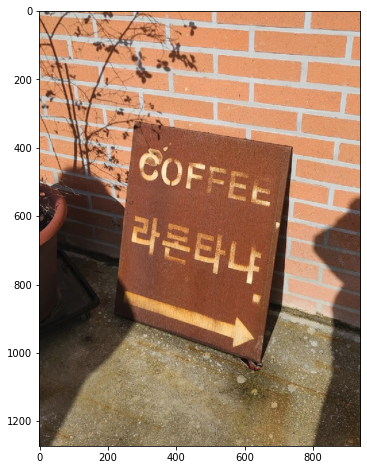

In [14]:
SAMPLE_IDX = 0
FIG_SIZE = (8, 8)

image = imread('test_images/image_01.png')
orig_size = image.shape[:2]

# image_fnames = sorted(ufo_anno['images'].keys())
# image_fname = image_fnames[SAMPLE_IDX]
# image_fpath = osp.join(DATASET_DIR, 'images', image_fname)
# image = imread(image_fpath)

print('Original image:\t{}'.format(image.shape))

plt.figure(figsize=FIG_SIZE)
plt.imshow(image)

### 일정 크기로 조정 (전처리)

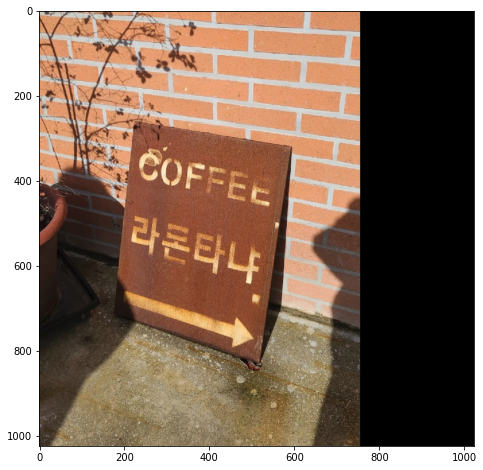

In [15]:
INPUT_SIZE = 1024

prep_fn = A.Compose([
    A.LongestMaxSize(INPUT_SIZE),
    A.PadIfNeeded(min_height=INPUT_SIZE, min_width=INPUT_SIZE, position=A.PadIfNeeded.PositionType.TOP_LEFT, border_mode=cv2.BORDER_CONSTANT),
    A.Normalize(), ToTensorV2()
])

# 시각화를 위해 Normalize와 Tensorize를 제외한 버전
prep_fn_vis = A.Compose([
    A.LongestMaxSize(INPUT_SIZE),
    A.PadIfNeeded(min_height=INPUT_SIZE, min_width=INPUT_SIZE, position=A.PadIfNeeded.PositionType.TOP_LEFT, border_mode=cv2.BORDER_CONSTANT)
])

vis = prep_fn_vis(image=image)['image']
plt.figure(figsize=FIG_SIZE)
plt.imshow(vis)

### 검출 결과 확인

x


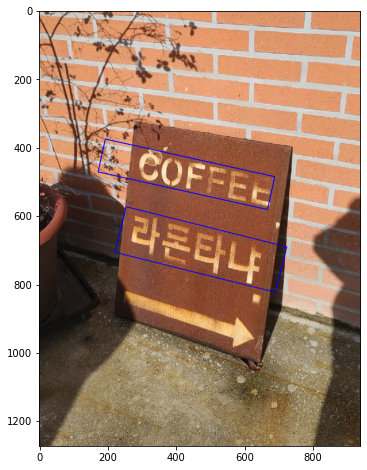

In [17]:
bboxes = detect(model, [image], INPUT_SIZE)[0]

vis = image.copy()
draw_bboxes(vis, bboxes, thickness=2)

plt.figure(figsize=FIG_SIZE)
plt.imshow(vis)

### 네트워크가 예측한 Map들을 시각화

Original image:	(1272, 939, 3)
Input image:	torch.Size([3, 1024, 1024])
Score map:	(256, 256)
Geometry map:	(256, 256, 5)


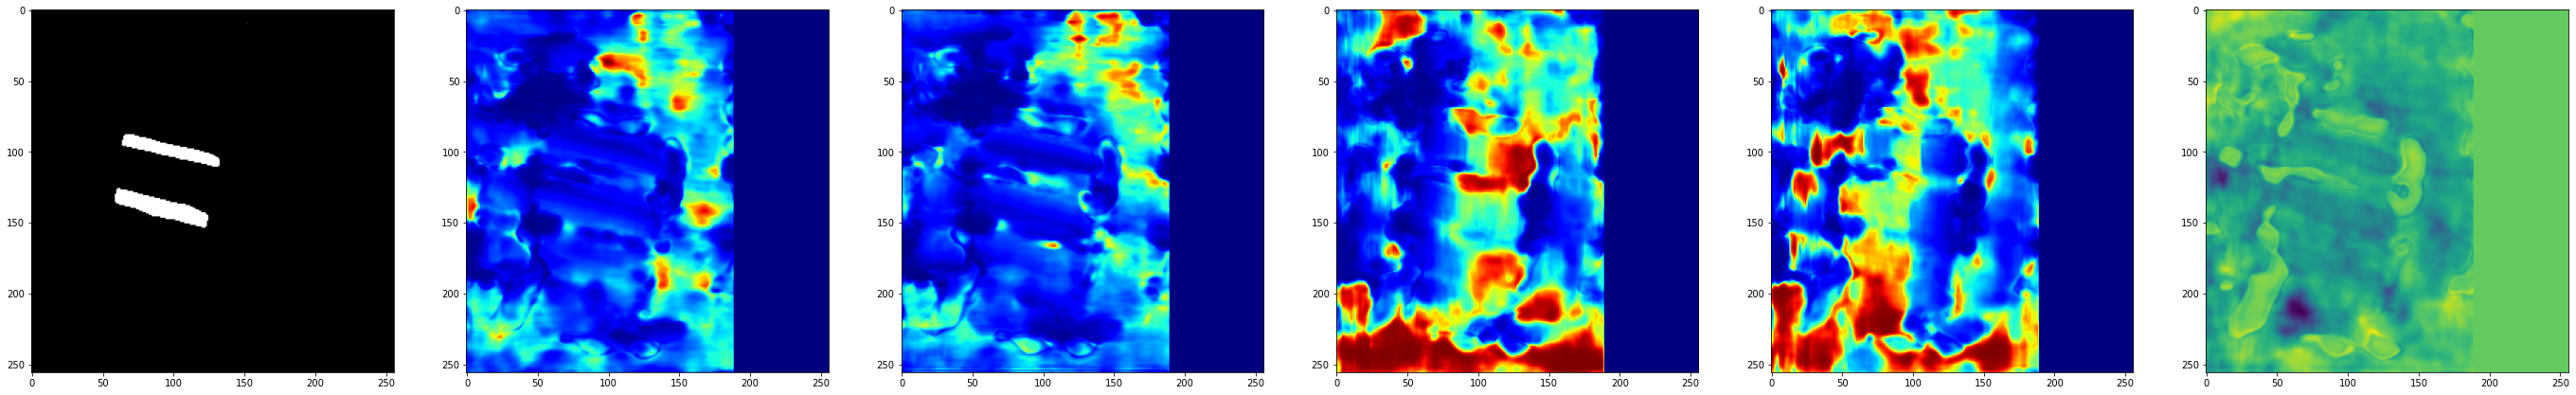

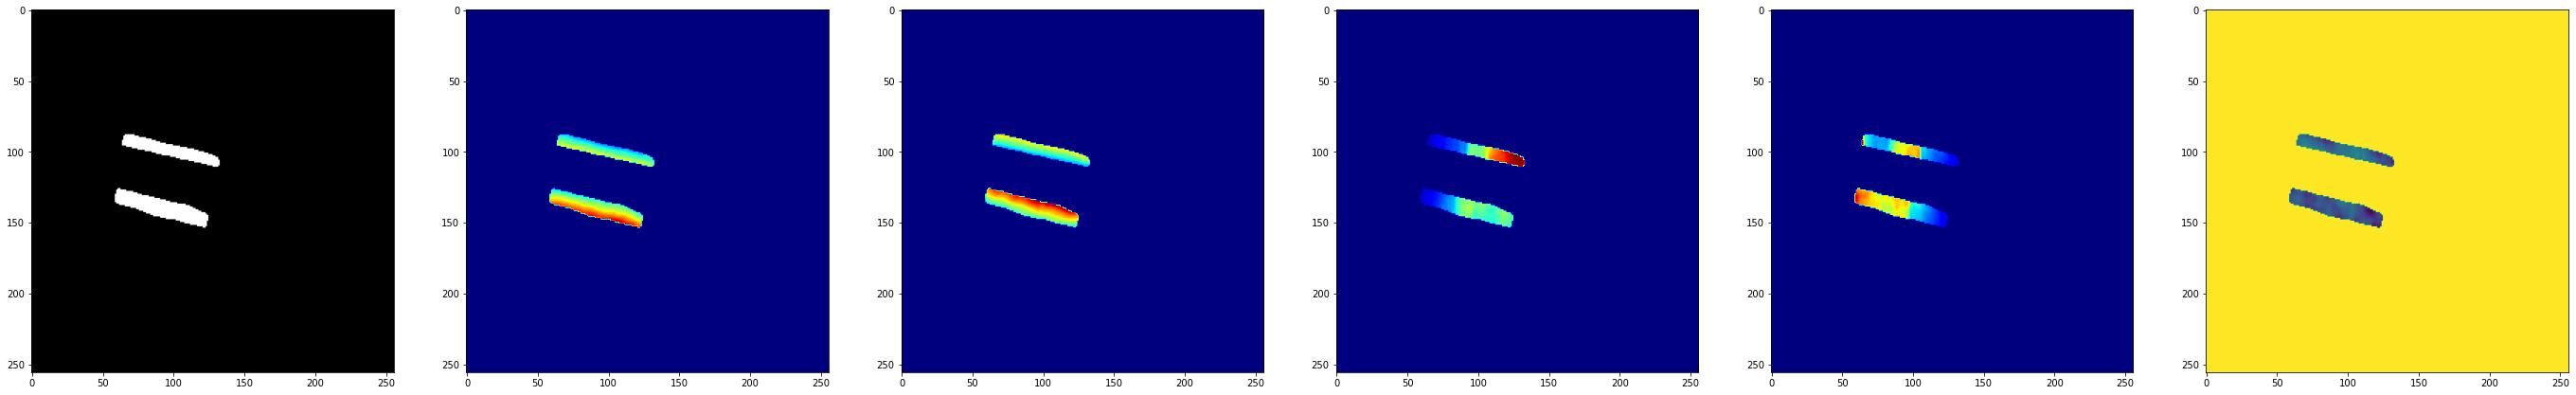

In [35]:
SCORE_THRES = 0.9

device = list(model.parameters())[0].device
batch = torch.stack([prep_fn(image=image)['image']], dim=0).to(device)

with torch.no_grad():
    score_maps, geo_maps = model(batch)
score_maps, geo_maps = score_maps.cpu().numpy(), geo_maps.cpu().numpy()
score_map, geo_map = score_maps[0], geo_maps[0]
score_map, geo_map = score_map.transpose(1, 2, 0), geo_map.transpose(1, 2, 0)
score_map = score_map.squeeze()

map_margin = int(abs(orig_size[0] - orig_size[1]) * MAP_SCALE * INPUT_SIZE / max(orig_size))
if map_margin > 0:
    if orig_size[0] > orig_size[1]:
        score_map[:, -map_margin:] = 0
        geo_map[:, -map_margin:, :] = 0
    else:
        score_map[-map_margin:, :] = 0
        geo_map[-map_margin:, :, :] = 0

fig, axs = plt.subplots(ncols=6, nrows=1, figsize=(FIG_SIZE[0] * 6, FIG_SIZE[1]))
axs[0].imshow(score_map, cmap='gray')
for idx in range(4):
    axs[idx + 1].imshow(geo_map[:, :, idx], cmap='jet')
axs[5].imshow(geo_map[:, :, 4])


center_mask = score_map > SCORE_THRES
fig, axs = plt.subplots(ncols=6, nrows=1, figsize=(FIG_SIZE[0] * 6, FIG_SIZE[1]))
axs[0].imshow(center_mask, cmap='gray')
for idx in range(4):
    axs[idx + 1].imshow(geo_map[:, :, idx] * center_mask, cmap='jet')
axs[5].imshow(geo_map[:, :, 4] * center_mask)

print('Original image:\t{}'.format(image.shape))
print('Input image:\t{}'.format(batch[0].shape))
print('Score map:\t{}'.format(score_map.shape))
print('Geometry map:\t{}'.format(geo_map.shape))

### 예측한 Score map과 Geometry map으로부터 Bounding box를 구하는 과정

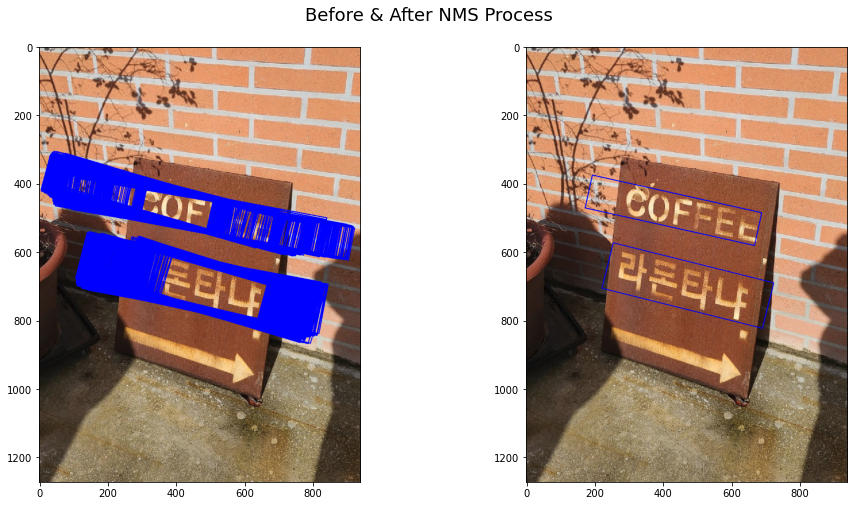

In [48]:
NMS_THRES = 0.2


xy_text = np.argwhere(score_map > SCORE_THRES)[:, ::-1].copy()  # (n x 2)

if xy_text.size == 0:
    bboxes = np.zeros((0, 4, 2), dtype=np.float32)
else:
    xy_text = xy_text[np.argsort(xy_text[:, 1])]  # Row-wise로 정렬
    valid_pos = xy_text * INV_MAP_SCALE
    valid_geo = geo_map[xy_text[:, 1], xy_text[:, 0], :]  # (n x 5)
    
    indices, bboxes = [], []
    for idx, ((x, y), g) in enumerate(zip(valid_pos, valid_geo)):
        y_min, y_max = y - g[0], y + g[1]
        x_min, x_max = x - g[2], x + g[3]
        rotate_mat = get_rotate_mat(-g[4])
        
        bbox = np.array([[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]], dtype=np.float32)
        anchor = np.array([x, y], dtype=np.float32).reshape(2, 1)
        rotated_bbox = (np.dot(rotate_mat, bbox.T - anchor) + anchor).T

        # 이미지 범위에서 벗어나는 bbox는 탈락
        if bbox[:, 0].min() < 0 or bbox[:, 0].max() >= score_map.shape[1] * INV_MAP_SCALE:
            continue
        elif bbox[:, 1].min() < 0 or bbox[:, 1].max() >= score_map.shape[0] * INV_MAP_SCALE:
            continue

        indices.append(idx)
        bboxes.append(rotated_bbox.flatten())
    bboxes = np.array(bboxes)
    
    raw_bboxes = bboxes.reshape(-1, 4, 2)
    
    # 좌표 정보에 Score map에서 가져온 Score를 추가
    scored_bboxes = np.zeros((bboxes.shape[0], 9), dtype=np.float32)
    scored_bboxes[:, :8] = bboxes
    scored_bboxes[:, 8] = score_map[xy_text[indices, 1], xy_text[indices, 0]]
    
    # LA-NMS 적용
    nms_bboxes = lanms.merge_quadrangle_n9(scored_bboxes.astype('float32'), NMS_THRES)
    nms_bboxes = nms_bboxes[:, :8].reshape(-1, 4, 2)
    
    # 원본 이미지 크기에 맞게 bbox 크기 보정
    raw_bboxes *= max(orig_size) / INPUT_SIZE
    nms_bboxes *= max(orig_size) / INPUT_SIZE

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(FIG_SIZE[0] * 2, FIG_SIZE[1]))
plt.suptitle('Before & After NMS Process', fontsize=18, y=0.95)

vis = image.copy()
draw_bboxes(vis, raw_bboxes[::], thickness=2)
axs[0].imshow(vis)

vis = image.copy()
draw_bboxes(vis, nms_bboxes, thickness=2)
axs[1].imshow(vis)